## Plot directly from a gridded NetCDF file that also has events and flashes in it. 

This notebook uses the grid times directly to set the time limits.

In [1]:
%matplotlib widget

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import glob
import os
import pandas as pd
import datetime

from pyxlma.lmalib.io import read
from pyxlma.plot.xlma_plot_feature import color_by_time, plot_points, setup_hist, plot_3d_grid, subset
from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot
import matplotlib.dates as md

M2KM = 1000.0
xdiv = 0.01
ydiv = 0.01
zdiv = 0.1

In [4]:
lma_data = xr.open_dataset('./LYLOUT_130619_200000_7200_map1000m.nc')

In [8]:
print(lma_data.event_chi2.attrs['valid_range'])
print(lma_data.event_stations.attrs['valid_range'])
# print(lma_data.event_time.encoding)
lma_data

[0. 5.]
[  6 255]


<xarray.Dataset>
Dimensions:                              (grid_time: 120, grid_time_edge: 121, grid_x: 250, grid_x_edge: 251, grid_y: 250, grid_y_edge: 251, number_of_events: 219640, number_of_flashes: 4308, number_of_stations: 13)
Coordinates:
  * grid_x                               (grid_x) float64 -1.245e+05 ... 1.24...
  * grid_y                               (grid_y) float64 -1.245e+05 ... 1.24...
  * grid_x_edge                          (grid_x_edge) float64 -1.25e+05 ... ...
  * grid_y_edge                          (grid_y_edge) float64 -1.25e+05 ... ...
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2013...
  * grid_time                            (grid_time) datetime64[ns] 2013-06-1...
  * number_of_flashes                    (number_of_flashes) uint64 3 ... 8190
    event_latitude                       (number_of_events) float32 31.346949...
    event_longitude                      (number_of_events) float32 -96.4831 ...
    event_time                           (number_of_events) datetime64[ns] 20...
    event_id                             (number_of_events) uint64 ...
    flash_time_start                     (number_of_flashes) datetime64[ns] ...
    flash_init_latitude                  (number_of_flashes) float32 ...
    flash_init_longitude                 (number_of_flashes) float32 ...
    flash_init_altitude                  (number_of_flashes) float32 ...
    flash_id                             (number_of_flashes) uint64 ...
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    flash_extent_density                 (grid_time, grid_y, grid_x) float64 ...
    average_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    stdev_flash_area                     (grid_time, grid_y, grid_x) float64 ...
    minimum_flash_area                   (grid_time, grid_y, grid_x) float64 ...
    average_flash_energy                 (grid_time, grid_y, grid_x) float64 ...
    event_count                          (grid_time, grid_y, grid_x) float64 ...
    event_total_power                    (grid_time, grid_y, grid_x) float64 ...
    network_center_latitude              float64 29.76
    network_center_longitude             float64 -95.37
    network_center_altitude              float64 ...
    station_latitude                     (number_of_stations) float32 29.9392...
    station_longitude                    (number_of_stations) float32 -95.646...
    station_altitude                     (number_of_stations) float32 ...
    station_event_fraction               (number_of_stations) float32 ...
    station_power_ratio                  (number_of_stations) float32 ...
    event_altitude                       (number_of_events) float32 8841.32 ....
    event_power                          (number_of_events) float32 ...
    event_mask                           (number_of_events) float64 ...
    event_stations                       (number_of_events) float32 6.0 ... 7.0
    event_chi2                           (number_of_events) float32 0.42 ... ...
    event_contributing_stations          (number_of_events, number_of_stations) float32 ...
    station_code                         (number_of_stations) |S1 ...
    flash_distance_separation_threshold  float64 ...
    flash_time_separation_threshold      timedelta64[ns] ...
    flash_duration_threshold             timedelta64[ns] ...
    flash_time_merge_threshold           timedelta64[ns] ...
    flash_time_end                       (number_of_flashes) datetime64[ns] ...
    flash_duration                       (number_of_flashes) timedelta64[ns] ...
    flash_area                           (number_of_flashes) float32 ...
    flash_volume                         (number_of_flashes) float32 ...
    flash_energy                         (number_of_flashes) float32 ...
    flash_center_latitude                (number_of_flashes) float32 ...
    flash_center_longitude               (number_of_flashes) float3

In [6]:
try:
    alt_data = lma_data.event_altitude.values/M2KM
    lon_data = lma_data.event_longitude.values
    lat_data = lma_data.event_latitude.values
    time_data = pd.Series(lma_data.event_time) # because time comparisons
    chi_data = lma_data.event_chi2.values
    station_data =lma_data.event_stations.values
# # Or the pandas version
# try:
#     alt_data = lma_data['alt(m)']/M2KM
#     lon_data = lma_data.lon
#     lat_data = lma_data.lat
#     time_data = lma_data.Datetime
#     chi_data = lma_data['reduced chi^2']
except:
    alt_data = np.array([])
    lon_data = np.array([])
    lat_data = np.array([])
    time_data = np.array([])
    chi_data = np.array([])
    station_data = np.array([])

/Users/ebruning/miniconda3/envs/lmatracer/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:762: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fb6993c79b0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


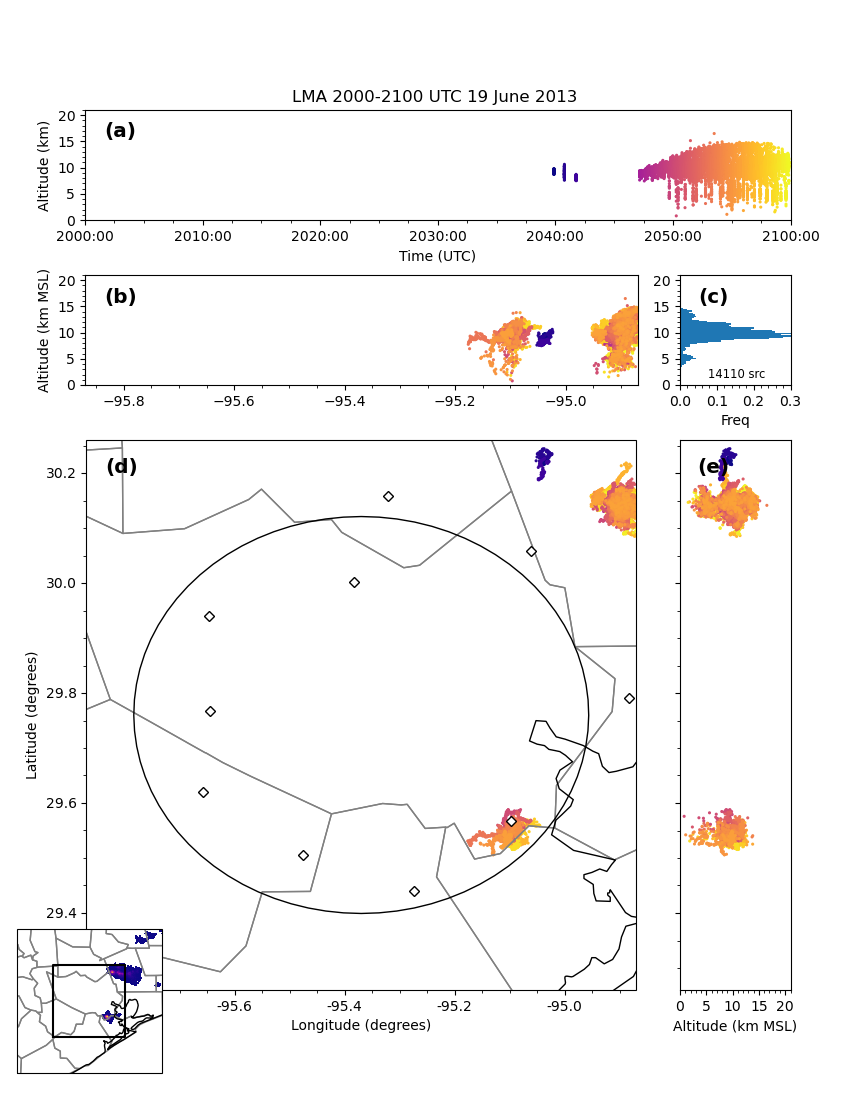

In [7]:
plot_cmap = 'plasma'
plot_s = 5

tlim_sub = [pd.to_datetime(lma_data.grid_time_edge.values[0]), pd.to_datetime(lma_data.grid_time_edge.values[60])]
tstring = 'LMA {}-{}'.format(tlim_sub[0].strftime('%H%M'),
                             tlim_sub[1].strftime('%H%M UTC %d %B %Y '))

clat, clon = float(lma_data.network_center_latitude), float(lma_data.network_center_longitude)
xlim = [clon-0.5, clon+0.5]
ylim = [clat-0.5, clat+0.5]
zlim = [0, 21]
xchi = 1.0
stationmin = 6.0

lon_set, lat_set, alt_set, time_set, selection = subset(
           lon_data, lat_data, alt_data, time_data, chi_data, station_data,
           xlim, ylim, zlim, tlim_sub, xchi, stationmin)

bk_plot = BlankPlot(pd.to_datetime(tlim_sub[0]), bkgmap=True, 
              xlim=xlim, ylim=ylim, zlim=zlim, tlim=tlim_sub, title=tstring)

# Add a view of where the subset is
inset_view(bk_plot, lon_data, lat_data, xlim, ylim, xdiv, ydiv,
          buffer=0.5, inset_size=0.15, plot_cmap = 'plasma', bkgmap = True)
# Add some subplot labels
subplot_labels(bk_plot)
# Add a range ring
bk_plot.ax_plan.tissot(rad_km=40.0, lons=clon, lats=clat, n_samples=80,
                  facecolor='none',edgecolor='k')
# Add the station locations
stn_art = bk_plot.ax_plan.plot(lma_data['station_longitude'], 
                               lma_data['station_latitude'], 'wD', mec='k', ms=5)

if len(lon_set)==0:
    bk_plot.ax_hist.text(0.02,1,'No Sources',fontsize=12)
else:
    plot_vmin, plot_vmax, plot_c = color_by_time(time_set, tlim_sub)
    plot_points(bk_plot, lon_set, lat_set, alt_set, time_set,
                      plot_cmap, plot_s, plot_vmin, plot_vmax, plot_c)

plt.show()
# plt.savefig('./images/' + dttuple[0].strftime('%y%m%d') +
#             '/relampago_points_' + dttuple[0].strftime('%Y%m%d_%H%M.png'))